# The Zero Order Hold trajectory leg

The zero order hold trajectory leg is implemented in `pykep` in the class {class}`pykep.leg.zoh`. Extending the concept of segments we find in the {class}`pykep.leg.sims_flanagan`, this leg accounts for a continuous thrust considered fixed in some frame along each segment of predefined length.

It thus approximates a thrust strategy via a sequence of continuous, constant thrust arcs (zero order hold). The leg is defined by a starting state $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, a final state $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time grid defining the various segment lengths.

A sequence of controls $\mathbf u = [T_0, i_{x0}, i_{y0}, i_{z0}, T_1, i_{x1}, i_{y1}, i_{z1}, T_2, i_{x2}, i_{y2}, i_{z2}, ... ]$ define the magnitude and direction of the continuous thrust vector along each segment).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.zoh` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import heyoka as hy
import numpy as np
import pygmo as pg
from copy import deepcopy

%matplotlib ipympl

In [2]:
# The integrators (Keplerian Propagation in Cartesian)
tol=1e-12
tol_var = 1e-8

ta_global = pk.ta.get_zoh_kep(tol)
ta_var_global = pk.ta.get_zoh_kep_var(tol_var)

# We test the zero hold leg

In [3]:
# To compute numerical gradients its convenientto have this API
def compute_mismatch_constraints_n(leg_mod, state0, controls, state1, tgrid):
   leg_mod.tgrid = tgrid
   leg_mod.state0 = state0
   leg_mod.state1 = state1
   leg_mod.controls = controls
   leg_mod.state1 = state1
   return leg_mod.compute_mismatch_constraints()

In [4]:
# We create a ballistic leg 
t0 = 10000
t1 = 10400
pl0 = pk.planet(pk.udpla.jpl_lp("Earth"))
pl1 = pk.planet(pk.udpla.jpl_lp("Mars"))
r0, v0 = pl0.eph(t0)
r1, v1 = pl1.eph(t1)
# We create some starting conditions from a Lambert arc
l = pk.lambert_problem(r0=r0, r1=r1, tof = (t1-t0) * pk.DAY2SEC, mu = pk.MU_SUN)
m0 = 1000
m1 = 1000

# Instantiate the leg 
# nd units
L = pk.AU
MU = pk.MU_SUN
TIME = np.sqrt(L**3/MU)
V =  L/TIME
ACC = V/TIME
MASS = 1000
F = MASS*ACC

# leg data
nseg = int(np.random.uniform(4, 20))
veff = np.random.uniform(4000, 8000) * pk.G0

# nd data
state0 = [it/L for it in r0] + [it/V for it in l.v0[0]] + [m0/MASS]
state1 = [it/L for it in r1] + [it/V for it in l.v1[0]] + [m1/MASS]
veff_nd = veff / V
tgrid = np.linspace(t0*pk.DAY2SEC/TIME, t1*pk.DAY2SEC/TIME, nseg+1)

controls = np.random.uniform(-1,1, (4*nseg,))
controls[0::4] /= (F * 100.)  # force will be in [-0.01, 0.01] N
controls[0::4] = np.abs(controls[0::4]) # force will be in [0.s, 0.01] N

cut = np.random.uniform(0,1)

ta_global.pars[4] = 1. / veff_nd
ta_var_global.pars[4] = 1. / veff_nd

leg = pk.leg.zoh(state0, controls.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])


In [5]:
grad_an = leg.compute_mc_grad()

In [6]:
# Chack on dmc/dx0
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, x, leg_copy.controls, leg_copy.state1, leg_copy.tgrid), leg.state0).reshape(7,-1)
np.linalg.norm(grad_num-grad_an[0])

7.6360502799351809e-07

In [7]:
# Chack on dmc/dxf
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, leg_copy.controls, x, leg_copy.tgrid), leg.state1).reshape(7,-1)
np.linalg.norm(grad_num-grad_an[1])

2.9807351829709244e-08

In [8]:
# Chack on dmc/dcontrols
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, x, leg_copy.state1, leg_copy.tgrid), leg.controls, dx=1e-8).reshape(7,-1)
np.linalg.norm(grad_num-grad_an[2])

8.1345473618274794e-07

In [9]:
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, leg_copy.controls, leg_copy.state1, x), leg.tgrid).reshape(7,-1)
np.linalg.norm(grad_num-grad_an[3])

2.8477478732524494e-09

Now the gradient is always well defined, non nans:

In [10]:
leg = pk.leg.zoh(state0, [0.1,0.2,0.3,0.4]*6, state1, np.linspace(0,400, 7)*pk.DAY2SEC/TIME, cut = cut, tas = [ta_global, ta_var_global])
dmcdx0, dmcdu, dmcdxf, dmdtgrid = leg.compute_mc_grad()
dmcdu

array([[-1.08152431, -0.25547883, -0.00780742,  1.18838536,  0.08750188,
         0.00429345,  0.01378947],
       [-0.24812962, -1.10657642, -0.00710157,  0.08624441,  1.16811653,
         0.00347645,  0.01976479],
       [-0.00832211, -0.00787106, -0.83669078,  0.00438701,  0.00361267,
         1.08912881,  0.02500049],
       [ 0.20509084,  0.42333179,  0.0190055 , -1.13498657, -0.2083262 ,
        -0.01439396, -0.02544184],
       [ 0.39485398,  0.12697882,  0.01465857, -0.20245185, -1.02308815,
        -0.01006157, -0.03457051],
       [ 0.02110555,  0.01775661, -0.25570452, -0.01485525, -0.01072098,
        -0.86227025, -0.04219498],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -1.        ]])

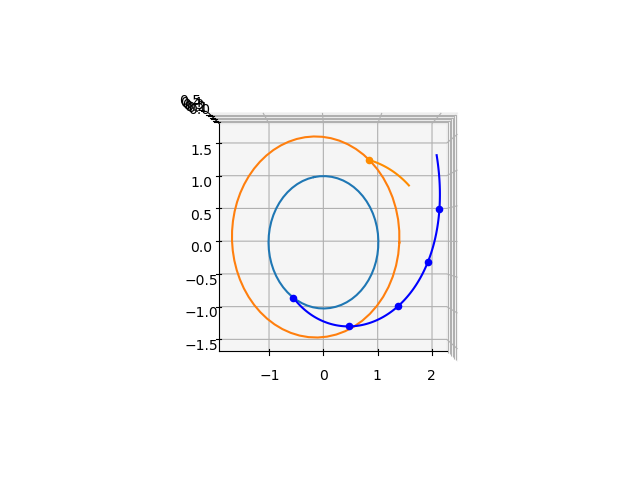

In [11]:
ax = pk.plot.make_3Daxis()
pk.plot.add_planet_orbit(ax, pl0, units=pk.AU)
pk.plot.add_planet_orbit(ax, pl1, units=pk.AU)
fwd, bck = leg.get_state_info(N=100)
for segment in fwd:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'blue') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'blue') 
for segment in bck:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'darkorange') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'darkorange') 

ax.view_init(90,-90)


In [12]:
def numtc(x):
    leg.controls = x
    return leg.compute_throttle_constraints()
numtc(leg.controls)

[-0.71, -0.71, -0.71, -0.71, -0.71, -0.71]

In [13]:
pg.estimate_gradient(numtc, leg.controls).reshape(leg.nseg,-1)

array([[ 0.        ,  0.4       ,  0.59999999,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.4       ,  0.59999999,  0.8       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.4       ,
         0.59999999,  0.8       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

In [24]:
tcg = leg.compute_tc_grad()

In [25]:
tcg.shape

(6, 24)

In [15]:
leg.nseg

6

In [23]:
dmdtgrid.shape

(7, 7)

In [22]:
dmcdx0, dmcdxf, dmcdu, dmdtgrid

(array([[ -5.52752792, -11.64599127,   0.1356844 ,   9.54237006,
         -12.56081911,   2.14550734,  -0.47522451],
        [  1.69964574,   8.22479663,  -0.46834075,  -2.64031575,
           8.80779795,  -0.84934994,  -0.45142218],
        [ -0.82620237,  -2.68863598,  -1.84394958,   1.78809396,
          -2.71609697,   1.35190014,  -0.55058588],
        [ -2.32133079,  -4.59882949,  -0.11096608,   3.72844598,
          -4.88139412,   1.00531314,  -0.30675232],
        [ -0.41080805,  -0.77844562,  -0.05293904,   0.29057289,
          -0.63022924,   0.07927705,  -0.18420823],
        [ -0.45899191,  -0.95905193,  -0.24255223,   0.93419832,
          -1.05941662,  -0.20591789,  -0.21366845],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   1.        ]]),
 array([[  9.41407405e-01,   1.17655769e+00,  -8.18864887e-01,
           2.10747728e-01,   1.83818835e+00,   8.52365036e-01,
          -1.45826446e-01,   1.09263587e-01,   1.2118